In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
!pip install openpyxl

## 데이터 불러오기

In [3]:
missing = pd.read_csv('./result/경찰청데이터_주소정리.csv', encoding='utf-8')

## 데이터 확인하기

In [4]:
missing.head()

,대상구분,실종나이,발생일시,등록일시,발견일시,발생지역,자치구
0,아동,5,1963-01-01 09:00,2015-01-08 17:34,2017-10-19 12:00,서울특별시 중구 을지로,중구
1,아동,3,1977-10-15 12:00,2015-03-17 15:20,2017-02-16 00:00,서울특별시 은평구 진관동,은평구
2,아동,3,1977-08-01 12:00,2015-10-02 14:13,2020-10-06 00:00,서울특별시 중구 회현동1가,중구
3,아동,1,2007-12-31 10:00,2016-02-19 18:30,2017-06-26 17:00,서울특별시 노원구 월계동,노원구
4,아동,0,2009-02-01 12:00,2016-03-17 11:21,2018-07-25 00:00,서울특별시 영등포구 영등포동,영등포구


## 기본 처리

In [140]:
missing.loc[missing['발생일시'] == '2020-04-18 20:', '발생일시'] = '2020-04-18 20:00'
missing.loc[missing['발견일시'] == '2018-02-03', '발견일시'] = '2018-02-03 00:00'

In [141]:
# 찾는데 소요된 시간을 구하기 위해 datetime객체로 변환
missing['발생일시'] = missing['발생일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))
missing['등록일시'] = missing['등록일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))
missing['발견일시'] = missing['발견일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))

### 참고자료
>[아동*청소년 휴대전화 보유 비율 2018년 기준](http://www.si.re.kr/node/65298)

## 원하는 데이터 뽑기

In [170]:
# 각 컬럼별 조건 부여해서 원하는 데이터만 뽑기
missing = missing.loc[(missing['대상구분'] == '아동') & (missing['실종나이'] >= 1) & (missing['실종나이'] <= 10), :]
missing = missing.loc[(missing['발생일시'].apply(lambda x: x.year) >= 2017), :]

### 장기실종으로 이어지는 경우
>“장기실종아동”이란 보호자로부터 신고를 접수한 지 48시간이 경과한 후에도 발견되지 않은 찾는 실종아동을 말한다[「실종아동등 및 가출인 업무처리 규칙」

In [171]:
missing0 = missing.copy()

In [172]:
missing0['소요시간'] = (missing0['발견일시'] - missing0['등록일시']).apply(lambda x: x.total_seconds()//3600)

In [173]:
missing0.value_counts('소요시간')

소요시간
 0.0        1251
-1.0         257
 1.0         243
 2.0          92
 3.0          61
-2.0          41
 4.0          31
 24.0         21
 6.0          17
 5.0          17
-3.0          16
 7.0          13
-12.0         11
 25.0         10
 8.0           9
 9.0           8
 10.0          8
 12.0          8
 23.0          7
 26.0          6
 13.0          6
 11.0          5
 22.0          4
 428.0         3
 86.0          3
 37.0          3
 30.0          3
 20.0          3
 16.0          3
-4.0           3
 167.0         3
-6.0           3
 226.0         2
 153.0         2
 413.0         2
-9.0           2
 47.0          2
-10.0          2
 51.0          2
 28.0          2
 27.0          2
-11.0          2
 43.0          2
 40.0          2
-5.0           2
-13.0          2
 19.0          2
 17.0          2
 15.0          2
 170.0         2
 415.0         1
 431.0         1
 215.0         1
 241.0         1
 396.0         1
 386.0         1
 344.0         1
 258.0         1
 495.0   

In [174]:
# 음수 처리
tmp = missing0.loc[missing0['소요시간'] < 0]
lst0 = tmp.index

missing0.loc[lst0, '소요시간'] = (missing0.loc[lst0, '등록일시'] - missing0.loc[lst0, '발견일시']).apply(lambda x: x.total_seconds()//3600)

In [175]:
tmp_result = pd.DataFrame(missing0.value_counts('소요시간'))

In [176]:
tmp_result.reset_index(inplace=True)
tmp_result.columns = ['소요시간', 'count']

In [177]:
tmp_result

,소요시간,count
0,0.0,1505
1,1.0,287
2,2.0,108
3,3.0,64
4,4.0,33
5,24.0,21
6,5.0,20
7,6.0,17
8,11.0,17
9,7.0,14


In [178]:
def gen_class(time):
    if time <= 1:
        return '1시간 이내'
    elif time <= 3:
        return '3시간'
    elif time <= 6:
        return '6시간'
    elif time <= 9:
        return '9시간'
    elif time <= 12:
        return '12시간'
    elif time <= 24:
        return '1일'
    elif time <= 2*24:
        return '2일'
    elif time <= 3*24:
        return '3일'
    elif time <= 7*24:
        return '7일'
    elif time <= 30*24:
        return '30일'
    elif time <= 365*24:
        return '1년'
    else:
        return '1년 이상'

In [179]:
tmp_result['구분'] = tmp_result['소요시간'].apply(lambda x: gen_class(int(x)))

In [180]:
tmp_g = tmp_result.groupby(by='구분')[['count']].sum()

In [181]:
tmp_g.value_counts(['구분', 'count'])

구분      count
12시간    36       1
1년      10       1
1년 이상   2        1
1시간 이내  1792     1
1일      53       1
2일      39       1
30일     38       1
3시간     172      1
3일      9        1
6시간     70       1
7일      23       1
9시간     35       1
dtype: int64

In [182]:
tmp_g.reset_index(inplace=True)

In [183]:
# 구분 기준으로 정렬
mapping = pd.DataFrame({
    '구분': ['1시간 이내', '3시간', '6시간', '9시간', '12시간', '1일', '2일', '3일', '7일', '30일', '1년', '1년 이상'],
})
sort_mapping = mapping.reset_index().set_index('구분')
sort_mapping

tmp_g['시간'] = tmp_g['구분'].map(sort_mapping['index'])
tmp_g.sort_values('시간', inplace=True)

tmp_g.drop('시간', axis=1, inplace=True)

In [184]:
tmp_g # 3시간을 기준으로 확연히 떨어짐을 볼 수 있음 --> 골든타임 : 3시간 이내

,구분,count
3,1시간 이내,1792
7,3시간,172
9,6시간,70
11,9시간,35
0,12시간,36
4,1일,53
5,2일,39
8,3일,9
10,7일,23
6,30일,38


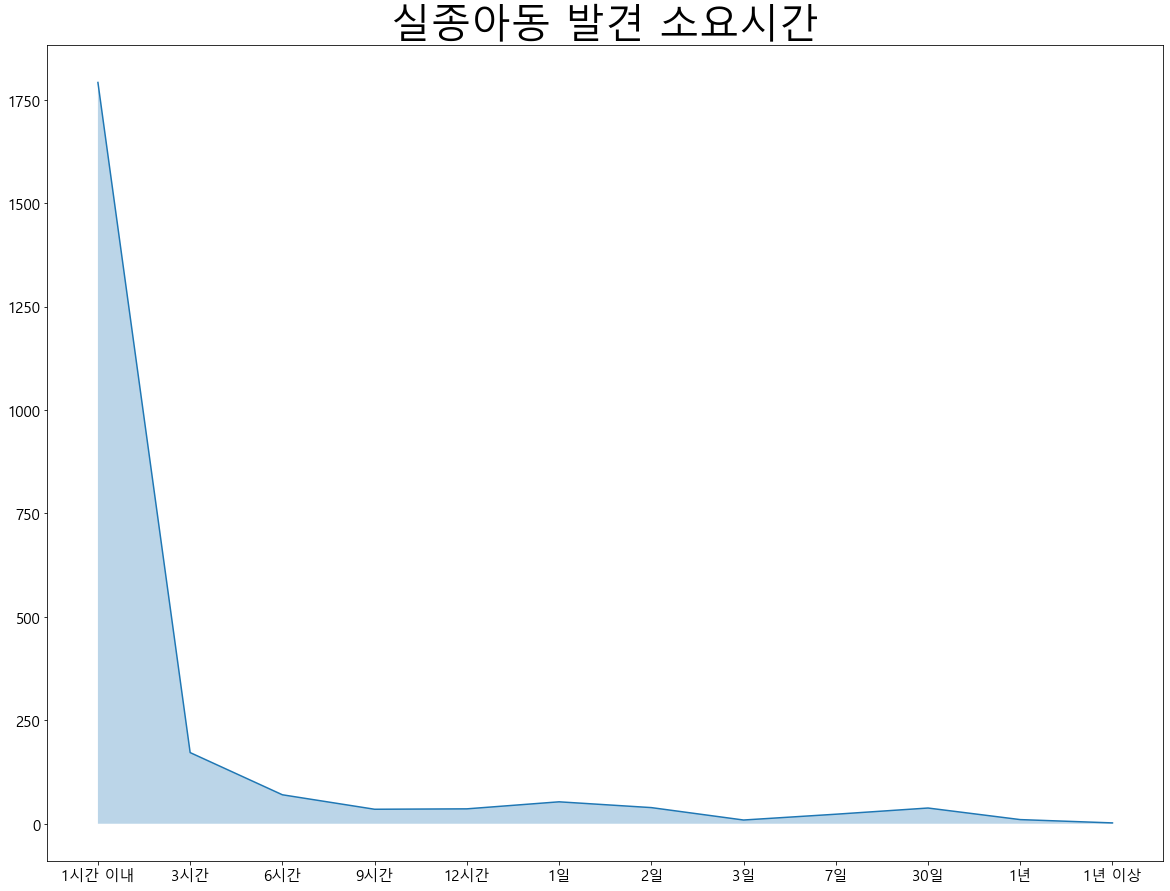

In [185]:
plt.figure(figsize=[20, 15])
plt.title('실종아동 발견 소요시간', fontsize=40)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(tmp_g['구분'], tmp_g['count'])
plt.fill_between(tmp_g['구분'][:], tmp_g['count'][:], alpha=0.3)
plt.savefig('./result/실종아동 발견 소요시간.png')